# Analysis of Museum Attendance

This notebook contains an analysis of museum attendance, based on data within the `museums.db` database (ETL script is in `etl.py`).

The analysis contains a linear regression model that predicts the number of visitors to a museum based on the population of the city in which the museum is located. The notebook also contains a visualization of the results.

In [53]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Use seaborn style defaults
sns.set()

In [42]:
conn = sqlite3.connect("museums.db")
sql_query = """
SELECT 
    city.name as city_name,
    city.population as city_population,
    museum.name as museum_name,
    museum.visitors_per_year,
    museum.year_reported
FROM museum INNER JOIN city ON museum.city = city.name;
"""
df = pd.read_sql(sql_query, conn)
df.head(3)

,city_name,city_population,museum_name,visitors_per_year,year_reported
0,Paris,11020000.0,Louvre,7800000,2022
1,Florence,382258.0,Galleria degli Uffizi,4000000,2022
2,Beijing,19433000.0,National Museum of China,2378000,2021


In [43]:
# Count of cities with more than one museum
count = len(df["city_name"].value_counts()[df["city_name"].value_counts() > 1])
print(f"Cities with more than one museum: {count}")
# Show the count of museums per city
df["city_name"].value_counts().head(5)

Cities with more than one museum: 15


London       6
Paris        4
Shanghai     3
Tokyo        3
Guangzhou    2
Name: city_name, dtype: int64

We notice immediately that many cities have multiple museums. To streamline the analysis, we will aggregate the data by city, taking the sum of the number of visitors to all museums in each city.

In [44]:
# Aggregate the data by city
df = df.groupby('city_name').agg({'visitors_per_year': 'sum', 'city_population': 'mean'})
# Add field visits_per_person, which represents the number of museum visits per inhabitant
df['visits_per_person'] = df['visitors_per_year'] / df['city_population']
df.head(3)

,visitors_per_year,city_population,visits_per_person
city_name,,,
Amsterdam,991359,1031000.0,0.961551
Beijing,4738000,19433000.0,0.243812
Changsha,460000,7044118.0,0.065303


Take a quick look at the data.

In [45]:
# Identify outliers in the data
df['visits_per_person'].describe()

count      37.000000
mean       53.536759
std       321.215717
min         0.021254
25%         0.148148
50%         0.333318
75%         0.689761
max      1954.581818
Name: visits_per_person, dtype: float64

The standard deviation is very large. We have outliers in the data. Let's take a look at the distribution of the number of visitors.

Text(0.5, 1.0, 'Number of cities with a certain number of visits per person')

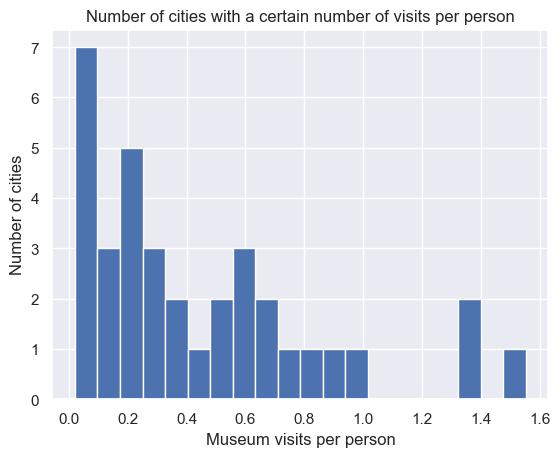

In [49]:
# Plot a histogram of the visits_per_person
# Keep visits_per_person between 0 and 2
df[df['visits_per_person'] < 2]['visits_per_person'].hist(bins=20)
# Label the axes
plt.xlabel('Museum visits per person')
plt.ylabel('Number of cities')
# Title
plt.title('Number of cities with a certain number of visits per person')

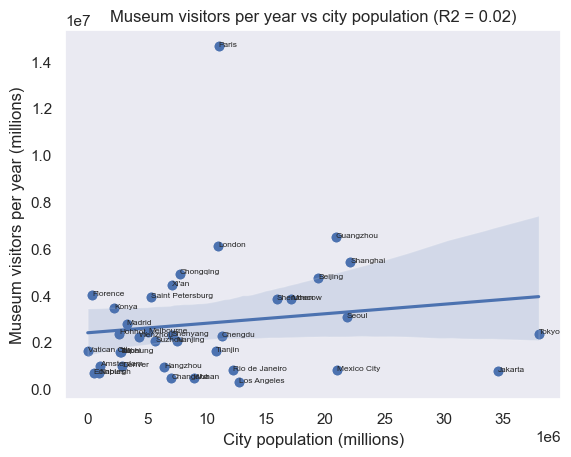

In [52]:
def show_plot():
    # Plot again, now that the outliers have been removed
    sns.set_style('dark')
    plt.scatter(df['city_population'], df['visitors_per_year'])
    # Label each point with the city name
    for i, txt in enumerate(df.index):
        plt.annotate(txt, (df['city_population'][i], df['visitors_per_year'][i]), fontsize=6)
    sns.regplot(x='city_population', y='visitors_per_year', data=df)
    r2 = np.corrcoef(df['city_population'], df['visitors_per_year'])[0,1] ** 2
    plt.title('Museum visitors per year vs city population (R2 = {:.2f})'.format(r2))
    plt.xlabel('City population (millions)')
    plt.ylabel('Museum visitors per year (millions)')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
    plt.show()
show_plot()

From the analysis above, it's clear that Tokyo, Paris, and Jakarta are outliers. Let's remove them from the dataset.

In [21]:
outliers = ["Tokyo", "Jakarta", "Paris"]

Let's also look at cities with anamolous "visits_per_person" values.

In [22]:
df["visits_per_person"].sort_values(ascending=False).head(4)

city_name
Vatican City    1954.581818
Florence          10.464137
Konya              1.551781
Edinburgh          1.353839
Name: visits_per_person, dtype: float64

In [23]:
# Identify cities with outliers in "Visits per person" and remove them
# Outlier if more than 3 standard deviations from the mean
outliers.extend(df[df['visits_per_person'] > df['visits_per_person'].mean() + 3 * df['visits_per_person'].std()].index.to_list())
print(f"Removing outliers: {outliers}")
df.drop(index=outliers, inplace=True)

Removing outliers: ['Tokyo', 'Jakarta', 'Paris', 'Vatican City']


In [25]:
# Check the statistics again, now that the outliers have been removed
df['visits_per_person'].describe()

count    33.000000
mean      0.753518
std       1.781529
min       0.021254
25%       0.199752
50%       0.333318
75%       0.636594
max      10.464137
Name: visits_per_person, dtype: float64

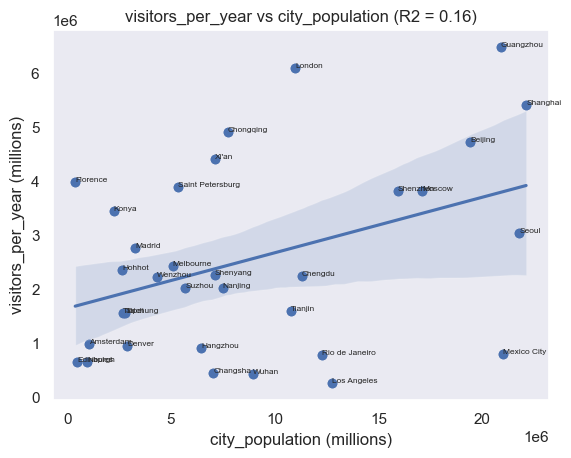

In [26]:
show_plot()

Size of training set: 26
Size of testing set: 7


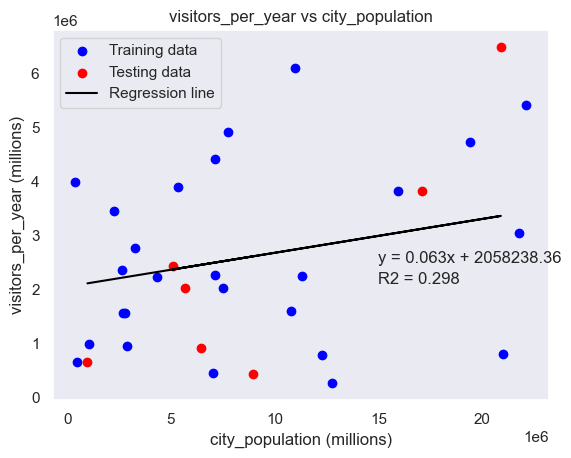

In [28]:
# Generate linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['city_population'], df['visitors_per_year'], test_size=0.2, random_state=42)
# Reshape the data
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
print(f"Size of training set: {len(X_train)}")
print(f"Size of testing set: {len(X_test)}")
# Create the model
model = LinearRegression()
# Fit the model to the training data
model.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = model.predict(X_test)

# Plot the training and testing data
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Testing data')
# Plot the regression line
plt.plot(X_test, y_pred, color='black', label='Regression line')
# Add the regression equation to the plot
plt.text(15e6, 2.5e6, f"y = {round(model.coef_[0], 3)}x + {round(model.intercept_, 3)}", fontsize=12)
# Also add the R2
R2 = round(model.score(X_test, y_test), 3)
plt.text(15e6, 2.1e6, f"R2 = {R2}", fontsize=12)
# Legend
plt.legend()
plt.title('visitors_per_year vs city_population')
plt.ylabel('visitors_per_year (millions)')
plt.xlabel('city_population (millions)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
plt.show()

## Caveats and Limitations

1. We did not analyze museums by geographic region (e.g. by country or continent). This would be an interesting analysis to perform.

2. We did not analyze museums by type (e.g. art, history, science, etc.). This would also be an interesting analysis to perform.

3. We did not verify the accuracy of the population data returned by an external API. Counting the number of people in a city is a difficult and nuanced task (e.g. metropolitan areas, suburbs, etc.). We assume that the population data returned by the API is accurate.

4. The museum attendance data is from different years. We did not account for this in the analysis. This is a source of error, especially given the impact of COVID-19 on museum attendance in 2020 and 2021.

5. Museums have different prices, hours, and other characteristics. We did not account for this in the analysis.